In [18]:
%matplotlib notebook
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt


In [4]:
class shortGridWorld():
    def __init__(self, start_state):
        self.state = start_state
        self.reward = -1
    
    def take_action(self, state, action):
        if state == 0:
            if all(action == np.array([[0.], [1.]])):
                self.state = 0
            else:
                self.state = 1
        elif state == 1:
            if all(action == np.array([[0.], [1.]])):
                self.state = 2
            else:
                self.state = 1
        elif state == 2:
            if all(action ==np.array([[0.],[1.]])):
                self.state = 1
            else:
                self.state = 3
            
    def is_terminal(self):
        return self.state == 3        

In [74]:
class REINFORCE_mc():
    def __init__(self, Problem, num_episodes=100, alpha_t=2**(-13), alpha_w = 0.001, y=0.9, max_ep_len=1000):
        self.Problem = Problem
        self.num_episodes = num_episodes
        self.y = y
        self.theta = np.array([[-1.47], [1.47]])
        self.w = 0
        self.x = np.array([[1.,0.],[0.,1.]])
        self.r = []
        self.s = []
        self.a = []
        self.G = []
        self.alpha_w = alpha_w
        self.alpha_t = alpha_t
        self.max_ep_len = max_ep_len
        
        self.I = []
        self.L = []
        
    def get_policy_distribution(self):
        return (np.exp(self.theta.T @ self.x)/np.sum(np.exp(self.theta.T @ self.x))).T
    
    def sample_from_distribution(self, P):
        CP = np.cumsum(P)
        if np.min(CP) < 0.05:
            CP[np.argmin(CP)] = 0.1
            CP[np.argmax(CP)] = 0.9
            
        rn = np.random.uniform()
        
        for i in range(len(CP)):
            if CP[i] >= rn:
                return i
    
    def get_action(self):
        action = np.zeros((2,1))

        # maybe a separate functon to get the feature vector of action
        action[self.sample_from_distribution(self.get_policy_distribution())] = 1 
        return action
    
    def clear(self):
        self.r = []
        self.s = []
        self.a = []
        
    def gen_episode(self,s0=0, max_len=1000):
        self.clear()
        problem = self.Problem(s0)
        
        state = s0
        self.s.append(state)
        
        G = 0
        I = 1
        
        while (not problem.is_terminal()) and max_len != 0:
            action = self.get_action()
            self.a.append(np.argmax(action))
            
            problem.take_action(state, action)
            state = problem.state
            self.s.append(state)
            
            self.r.append(problem.reward)
            G += problem.reward * I
            I *= self.y
            
            max_len -= 1
        
        self.G.append(G)
        self.I.append(I)
        self.L.append((len(self.a), self.G[-1]))
        
        return G
    
    def mc(self):
        alpha = self.alpha_t
        for i in tqdm(range(self.num_episodes)):
            G = self.gen_episode(0, self.max_ep_len)
            sub = 0
            I = 1
            
            for t in range(len(self.s)-1):
                G -= sub
                delta_ln = np.copy(self.x[:,self.a[t], np.newaxis])
                pi = self.get_policy_distribution()
                delta_ln -= self.x @ pi
    
                # y^t is covered in G in this implementation. G is not strictly G, rather y^t*G
                self.theta = self.theta + alpha*G*delta_ln 
                
                sub = self.r[t]*I
                I *= self.y
                
    def mc_with_baseline(self):
        alpha = self.alpha_t
        alpha_w = self.alpha_w
        
        for i in tqdm(range(self.num_episodes)):
            G = self.gen_episode(0, self.max_ep_len)
            sub = 0
            I = 1
            
            for t in range(len(self.s)-1):
                G -= sub # here G is the proper G, ie does not contain y^t
                G /= I
                delta = G - self.w
                
                self.w += alpha_w*delta
                
                delta_ln = np.copy(self.x[:,self.a[t], np.newaxis])
                pi = self.get_policy_distribution()
                delta_ln -= self.x @ pi
                self.theta += alpha*I*delta*delta_ln 
                
                sub = self.r[t]
                I *= self.y
                
            

In [ ]:
def run(agent, algo, problem, num_episodes, alpha_t=2**(-12), alpha_w = 0.0001, y=1, max_ep_len=1000):
    rew = np.zeros((num_ep_per_trial,1))
    for i in tqdm(range(num_trials)):
        a = agent(shortGridWorld, num_episodes=num_episodes, alpha_t=alpha_t, alpha_w=alpha_w, y=y, max_ep_len=max_ep_len)    
        algo()
        rew += np.reshape(np.array(a.G), (num_ep_per_trial,1))
        a.G = []
        a.L = []
    

In [90]:
num_trials = 100
num_ep_per_trial = 1000
alpha_t = 2**(-10)
alpha_w = alpha_t*100

rew3 = np.zeros((num_ep_per_trial,1))
for i in tqdm(range(num_trials)):
    a = REINFORCE_mc(shortGridWorld, num_episodes=num_ep_per_trial, alpha_t=alpha_t, y=1, max_ep_len=1000)    
    a.mc()
    rew3 += np.reshape(np.array(a.G), (num_ep_per_trial,1))
    a.G = []
    a.L = []
    
print(rew3/num_trials)

[[-56.73]
 [-49.24]
 [-53.44]
 [-43.35]
 [-42.32]
 [-41.24]
 [-34.44]
 [-31.1 ]
 [-32.79]
 [-41.01]
 [-43.54]
 [-39.76]
 [-43.09]
 [-37.7 ]
 [-38.39]
 [-38.53]
 [-38.35]
 [-38.4 ]
 [-38.59]
 [-37.71]
 [-35.91]
 [-31.75]
 [-36.2 ]
 [-36.35]
 [-36.4 ]
 [-35.97]
 [-37.92]
 [-36.63]
 [-35.94]
 [-36.44]
 [-36.15]
 [-31.74]
 [-36.24]
 [-35.63]
 [-34.97]
 [-34.31]
 [-34.22]
 [-27.01]
 [-24.58]
 [-25.46]
 [-28.81]
 [-26.01]
 [-24.68]
 [-25.07]
 [-23.9 ]
 [-26.37]
 [-25.39]
 [-25.12]
 [-26.06]
 [-24.8 ]
 [-23.34]
 [-27.12]
 [-22.73]
 [-26.23]
 [-24.44]
 [-24.51]
 [-24.12]
 [-23.92]
 [-24.16]
 [-24.45]
 [-25.63]
 [-23.78]
 [-24.85]
 [-22.53]
 [-22.97]
 [-21.98]
 [-24.07]
 [-23.92]
 [-25.27]
 [-22.9 ]
 [-22.65]
 [-23.81]
 [-24.05]
 [-24.24]
 [-22.77]
 [-23.84]
 [-23.04]
 [-22.84]
 [-22.3 ]
 [-23.18]
 [-22.74]
 [-23.84]
 [-24.35]
 [-22.38]
 [-21.64]
 [-23.46]
 [-22.18]
 [-23.33]
 [-24.65]
 [-22.41]
 [-23.05]
 [-20.89]
 [-22.42]
 [-23.04]
 [-23.21]
 [-23.11]
 [-21.88]
 [-23.3 ]
 [-25.06]
 [-22.16]


In [85]:
a.get_policy_distribution()

array([[1.58214365e-15],
       [1.00000000e+00]])

In [87]:
# num_trials = 100
# num_ep_per_trial = 1000
alpha_t = 2**(-8)
alpha_w = alpha_t*10

rew2 = np.zeros((num_ep_per_trial,1))
for i in tqdm(range(num_trials)):
    a = REINFORCE_mc(shortGridWorld, num_episodes=num_ep_per_trial, alpha_t=alpha_t, alpha_w = alpha_w, y=1, max_ep_len=1000)    
    a.mc_with_baseline()
    rew2 += np.reshape(np.array(a.G), (num_ep_per_trial,1))
    a.G = []
    a.L = []
    
print(rew2/num_trials)

[[-67.34]
 [-42.51]
 [-41.25]
 [-33.69]
 [-37.68]
 [-31.25]
 [-25.85]
 [-30.05]
 [-28.1 ]
 [-22.68]
 [-23.05]
 [-19.96]
 [-22.77]
 [-21.72]
 [-17.48]
 [-17.47]
 [-16.23]
 [-15.73]
 [-15.03]
 [-16.12]
 [-15.63]
 [-13.77]
 [-12.25]
 [-12.94]
 [-11.71]
 [-10.88]
 [-12.2 ]
 [-11.49]
 [-11.5 ]
 [-11.55]
 [-11.24]
 [-10.85]
 [ -9.93]
 [ -9.55]
 [-10.79]
 [-11.25]
 [-10.86]
 [ -9.3 ]
 [-10.58]
 [ -9.94]
 [ -9.85]
 [ -8.66]
 [-10.19]
 [ -8.61]
 [ -9.29]
 [ -9.34]
 [ -9.05]
 [ -9.23]
 [ -9.02]
 [ -8.35]
 [ -9.28]
 [ -8.23]
 [ -8.23]
 [ -8.85]
 [ -7.99]
 [ -7.72]
 [ -8.49]
 [ -7.99]
 [ -7.86]
 [ -8.18]
 [ -8.68]
 [ -8.61]
 [ -8.57]
 [ -6.97]
 [ -8.42]
 [ -7.32]
 [ -7.78]
 [ -7.5 ]
 [ -8.18]
 [ -8.01]
 [ -8.13]
 [ -7.84]
 [ -7.75]
 [ -7.8 ]
 [ -7.28]
 [ -8.12]
 [ -8.71]
 [ -8.14]
 [ -7.7 ]
 [ -7.49]
 [ -7.54]
 [ -7.71]
 [ -7.06]
 [ -7.72]
 [ -7.07]
 [ -7.66]
 [ -7.91]
 [ -8.19]
 [ -7.43]
 [ -8.09]
 [ -7.88]
 [ -7.69]
 [ -8.09]
 [ -7.14]
 [ -8.08]
 [ -7.77]
 [ -8.58]
 [ -8.38]
 [ -7.77]
 [ -8.01]


<IPython.core.display.Javascript object>


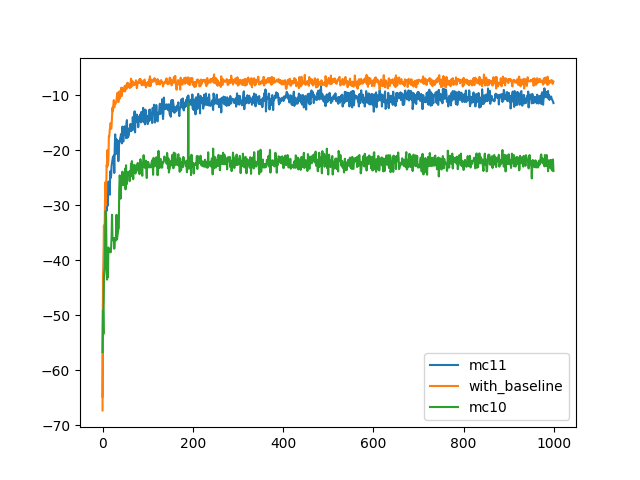

In [91]:
plt.plot(rew/num_trials, label='mc11')
plt.plot(rew2/num_trials, label='with_baseline')
plt.plot(rew3/num_trials, label='mc10')
plt.legend()
plt.show()